# Classificação logística de dígitos MNist

Esse notebook contemplará todo o pipeline até o treinamento e pode ser generalizado para futuros processos

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
from IPython import display
from dataset import load_mnist


ds_train, ds_valid = load_mnist()

d:\Programs\miniconda3\envs\visao\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


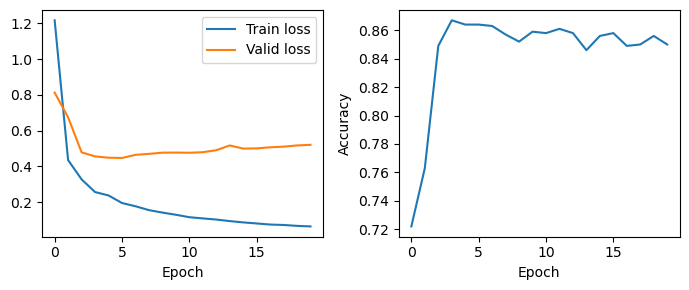

In [2]:
class Model(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        # As imagens 28x28 serão transformadas em vetores 1d, ou seja, cada imagem terá 28 atributos
        
        # Matriz de 10 linhas e 784 colunas
        # Cada linha é uma função para combinar os valores dos atributos e calcula a probabilidade de ser de cada uma das classes (1 a 10)
        self.layer = nn.Linear(28*28, 10)
        
    def forward(self, x):
        """ Recebe a imagem 28x28 e redimensiona em array/tensor 1D """
        # batch_size x 1 x 28 x 28 -> batch_size x 28*28
        x = x.reshape(x.shape[0], -1)
        return self.layer(x)

def train_step(model, dl_train, optim, loss_func):
    """ Executa uma época do treinamento """
    
    # Coloca o modelo em modo treinamento
    model.train()
    loss_log = 0.
    
    for imgs, targets in dl_train:
        scores = model(imgs)
        
        loss = loss_func(scores, targets)
        # Zera os gradientes calculados previamente
        optim.zero_grad()
        # Acumula os gradientes já calculados
        loss.backward()
        print(loss)
        # Realiza uma etapa no otimizador
        optim.step()
        
        # Remove a variável do grafo de computação e resgata somente o valor
        # Pode-se usar loss.item() com atenção, pois o .item() sincroniza com a GPU e pode deixar a GPU ociosa
        # .detach apenas tira do grafo de computação, .item() faz uma cópia da GPU para CPU e converte o valor  
        loss_log += loss.detach() * imgs.shape[0] # Incrementa a loss para cada imagem
        
    # Calcula a média da loss para todas imagens
    loss_log /= len(dl_train.dataset)
    
    return loss_log

def accuracy(scores,targets):
    # Scores: batch_size x 10
    # Para cada linha de 'scores', retorna o índice de maior valor
    pred = scores.argmax(dim=1)
    return (pred==targets).float().mean()

# validação
@torch.no_grad()
def valid_step(model, dl_valid, loss_func, perf_func):
    """ perf_func é uma função que mede a performance (função accuracy) """
    
    # Coloca o modelo em modo treinamento
    model.eval()
    # Variáveis que armazenarão a loss e a acurácia
    loss_log = 0.
    perf_log = 0.
    for imgs, targets in dl_valid:
        scores = model(imgs)
        loss = loss_func(scores, targets)
        perf = perf_func(scores, targets)

        # Multiplica por batch_size porque o último batch pode ter tamanho diferente
        loss_log += loss*imgs.shape[0]
        perf_log += perf*imgs.shape[0]

    # Média dos valores calculados
    loss_log /= len(dl_valid.dataset)
    perf_log /= len(dl_valid.dataset)
    
    return loss_log.item(), perf_log.item()


def show_log(logger):

    epochs, losses_train, losses_valid, accs = zip(*logger)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7,3))
    ax1.plot(epochs, losses_train, label='Train loss')
    ax1.plot(epochs, losses_valid, label='Valid loss')
    ax1.set_xlabel('Epoch')
    ax1.legend()
    ax2.plot(epochs, accs)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    fig.tight_layout()

    display.clear_output(wait=True) 
    plt.show()
    
def train(model, ds_train, ds_valid, bs, num_epochs, lr, perf_func):
    
    dl_train = DataLoader(ds_train, batch_size=bs, shuffle=True)
    dl_valid = DataLoader(ds_valid, batch_size=bs, shuffle=False)

    loss_func = nn.CrossEntropyLoss()
    optim = torch.optim.SGD(model.parameters(), lr=lr)
    logger = []
    for epoch in range(0, num_epochs):
        loss_train = train_step(model, dl_train, optim, loss_func)
        loss_valid, perf = valid_step(model, dl_valid, loss_func, perf_func)
        logger.append((epoch, loss_train, loss_valid, perf))
        show_log(logger)
    
    return logger
model = Model()
logger = train(model, ds_train, ds_valid, bs=64, num_epochs=20, lr=0.1, perf_func=accuracy)

In [3]:
a = torch.randn(1, 4)
print(a)
torch.argmax(a)

tensor([[ 0.8028,  0.4263, -0.8370,  0.6835]])


tensor(0)

In [4]:
model = Model()
x = torch.rand(16,1,28,28)
res = model(x)
res.shape

torch.Size([16, 10])

In [5]:
a = Model()
d = a.forward(ds_train[0])

AttributeError: 'tuple' object has no attribute 'reshape'